In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bob_ross = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-21/bob_ross.csv')

In [ ]:
bob_ross.shape, bob_ross.columns[:15]

((403, 27),
 Index(['painting_index', 'img_src', 'painting_title', 'season', 'episode',
        'num_colors', 'youtube_src', 'colors', 'color_hex', 'Black_Gesso',
        'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna',
        'Indian_Red'],
       dtype='object'))

In [ ]:
bob_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   painting_index    403 non-null    int64 
 1   img_src           403 non-null    object
 2   painting_title    403 non-null    object
 3   season            403 non-null    int64 
 4   episode           403 non-null    int64 
 5   num_colors        403 non-null    int64 
 6   youtube_src       403 non-null    object
 7   colors            403 non-null    object
 8   color_hex         403 non-null    object
 9   Black_Gesso       403 non-null    bool  
 10  Bright_Red        403 non-null    bool  
 11  Burnt_Umber       403 non-null    bool  
 12  Cadmium_Yellow    403 non-null    bool  
 13  Dark_Sienna       403 non-null    bool  
 14  Indian_Red        403 non-null    bool  
 15  Indian_Yellow     403 non-null    bool  
 16  Liquid_Black      403 non-null    bool  
 17  Liquid_Clear    

# preprocessing

In [ ]:
# Drop columns not needed for Q2 analysis
drop_cols = ["img_src", "youtube_src", "painting_title", "color_hex"]
bob_clean = bob_ross.drop(columns=drop_cols)

meta_cols = ["painting_index", "season", "episode", "num_colors", "colors"]
X_colors = bob_clean.drop(columns=meta_cols)

# Boolean palette matrix
X_bool_df = X_colors.astype(bool)
X_bool = X_bool_df.to_numpy()

print("X_bool shape:", X_bool.shape)
print("Unique values:", np.unique(X_bool))
print("Palette size min/mean/max:", X_bool.sum(axis=1).min(), X_bool.sum(axis=1).mean(), X_bool.sum(axis=1).max())

X_bool shape: (403, 18)
Unique values: [False  True]
Palette size min/mean/max: 1 10.605459057071961 15


In [ ]:
# Co-occurrence counts across paintings: C[i,j] = number of paintings where both colors appear
X_int = X_bool_df.astype(int).to_numpy()
co_count = X_int.T @ X_int  # (n_colors, n_colors)

color_names = X_bool_df.columns.to_list()
co_df = pd.DataFrame(co_count, index=color_names, columns=color_names)

# Optional: convert to co-occurrence rate by dividing by number of paintings
co_rate = co_df / X_int.shape[0]

# Show top pairs (excluding diagonal)
pairs = []
for i in range(len(color_names)):
    for j in range(i+1, len(color_names)):
        pairs.append((color_names[i], color_names[j], co_df.iat[i, j], co_rate.iat[i, j]))
top_pairs = pd.DataFrame(pairs, columns=["color_a", "color_b", "count", "rate"]).sort_values("count", ascending=False)

top_pairs.head(15)

,color_a,color_b,count,rate
149,Titanium_White,Alizarin_Crimson,378,0.937965
147,Titanium_White,Van_Dyke_Brown,369,0.915633
151,Van_Dyke_Brown,Alizarin_Crimson,354,0.878412
58,Cadmium_Yellow,Titanium_White,345,0.856079
61,Cadmium_Yellow,Alizarin_Crimson,335,0.831266
59,Cadmium_Yellow,Van_Dyke_Brown,327,0.811414
148,Titanium_White,Yellow_Ochre,326,0.808933
128,Phthalo_Blue,Titanium_White,323,0.801489
29,Bright_Red,Titanium_White,319,0.791563
152,Yellow_Ochre,Alizarin_Crimson,317,0.786600


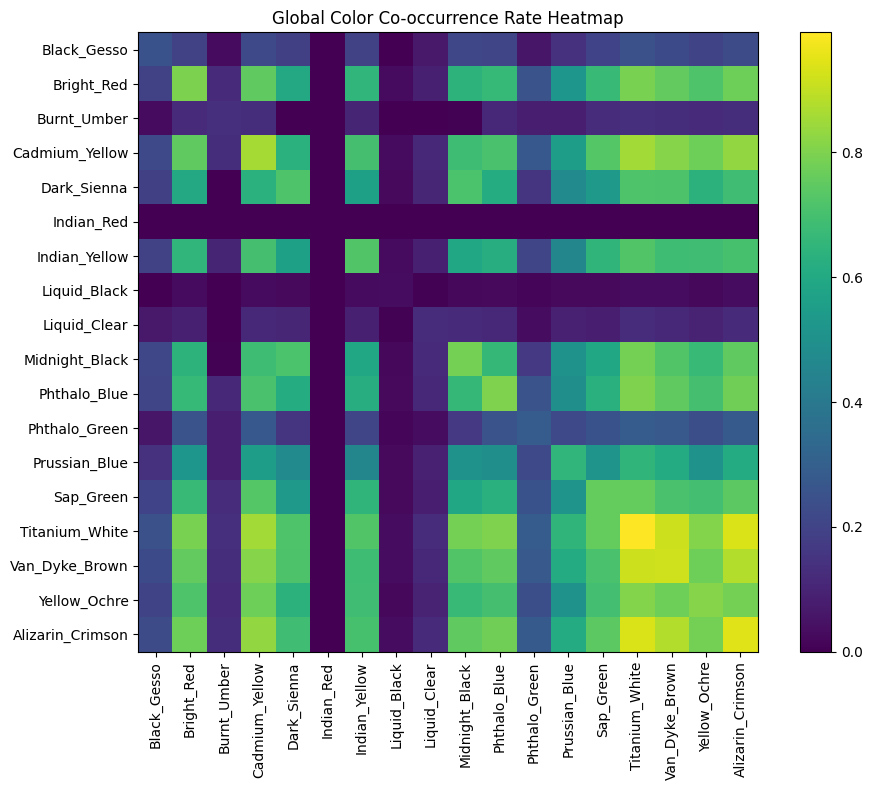

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(co_rate.values)
plt.xticks(range(len(color_names)), color_names, rotation=90)
plt.yticks(range(len(color_names)), color_names)
plt.title("Global Color Co-occurrence Rate Heatmap")
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
# Color occurrence probability
p_i = X_int.mean(axis=0)
p_i = pd.Series(p_i, index=color_names)

# Lift
lift_matrix = co_rate.copy()

for i in range(len(color_names)):
    for j in range(len(color_names)):
        if p_i.iloc[i] * p_i.iloc[j] > 0:
            lift_matrix.iloc[i, j] = co_rate.iloc[i, j] / (p_i.iloc[i] * p_i.iloc[j])
        else:
            lift_matrix.iloc[i, j] = 0

np.fill_diagonal(lift_matrix.values, 1)

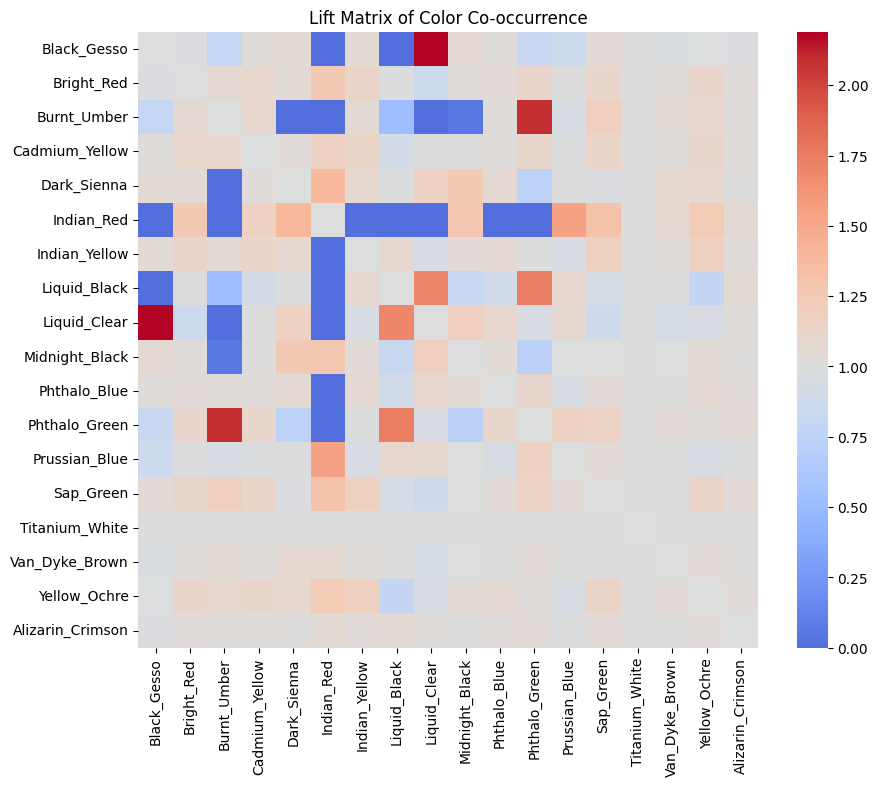

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(lift_matrix, cmap="coolwarm", center=1)
plt.title("Lift Matrix of Color Co-occurrence")
plt.show()

# Hierarchical Clustering

In [ ]:
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

USE_M3_COMPAT = True
# Distance matrix
jaccard_dist = pairwise_distances(X_bool, metric="jaccard")

if USE_M3_COMPAT:
    # M3-compatible
    Z = linkage(jaccard_dist, method="average")
else:
    # Strict version
    dist_vec = squareform(jaccard_dist, checks=False)
    Z = linkage(dist_vec, method="average")

In [ ]:
from sklearn.metrics import jaccard_score

# Canonical palette = colors used in >50% of paintings
canonical_rate = X_bool_df.mean(axis=0)
canonical_binary = (canonical_rate > 0.5).astype(int)

X_int_df = X_bool_df.astype(int)

def deviation_from_canonical(row, canonical):
    return 1 - jaccard_score(row.values, canonical.values)

bob_clean["deviation_score"] = X_int_df.apply(lambda r: deviation_from_canonical(r, canonical_binary), axis=1)

bob_clean["deviation_score"].describe()

,deviation_score
count,403.000000
mean,0.235566
std,0.185986
min,0.000000
25%,0.083333
50%,0.200000
75%,0.357143
max,0.916667


<Axes: xlabel='deviation_score', ylabel='Count'>

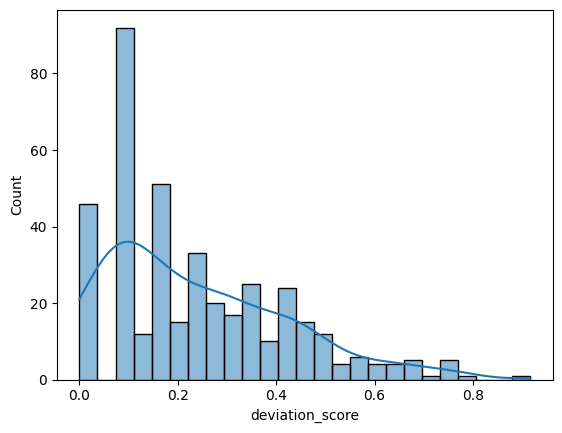

In [ ]:
import seaborn as sns
sns.histplot(bob_clean["deviation_score"], bins=25, kde=True)

In [ ]:
from scipy.cluster.hierarchy import fcluster

k = 4
labels_k4 = fcluster(Z, t=k, criterion="maxclust")
bob_clean["cluster_k4"] = labels_k4

print("Cluster proportions (k=4):")
print(pd.Series(labels_k4).value_counts(normalize=True))

Cluster proportions (k=4):
1    0.655087
2    0.282878
3    0.059553
4    0.002481
Name: proportion, dtype: float64


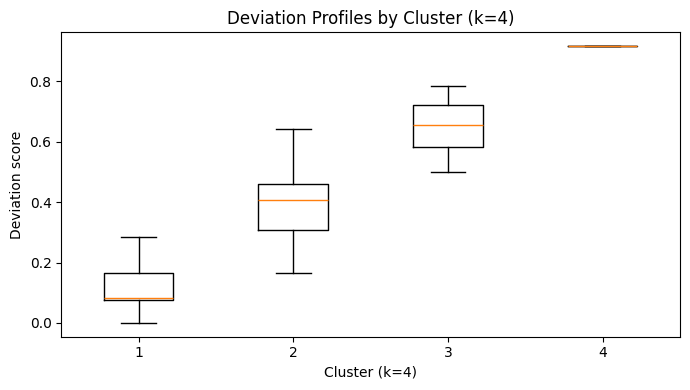

In [ ]:
groups = []
for c in sorted(bob_clean["cluster_k4"].unique()):
    groups.append(bob_clean.loc[bob_clean["cluster_k4"] == c, "deviation_score"].values)

plt.figure(figsize=(7,4))
plt.boxplot(groups, labels=sorted(bob_clean["cluster_k4"].unique()), showfliers=False)
plt.xlabel("Cluster (k=4)")
plt.ylabel("Deviation score")
plt.title("Deviation Profiles by Cluster (k=4)")
plt.tight_layout()
plt.show()

# Experiment A — k sensitivity

In [ ]:
from sklearn.metrics import pairwise_distances, silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import pandas as pd
import numpy as np

def run_grid(X_data, deviation_scores, metrics, linkages, k_list):
    results = []
    for metric in metrics:
        dist_mat = pairwise_distances(X_data, metric=metric)
        # Fill potential NaNs (e.g., from cosine similarity of zero vectors)
        dist_mat[np.isnan(dist_mat)] = 0.0
        np.fill_diagonal(dist_mat, 0.0)

        dist_vec = squareform(dist_mat, checks=False)

        for link_method in linkages:
            Z = linkage(dist_vec, method=link_method, optimal_ordering=True)

            for k in k_list:
                labels = fcluster(Z, t=k, criterion="maxclust")
                sil = silhouette_score(dist_mat, labels, metric="precomputed")

                size_counts = pd.Series(labels).value_counts(normalize=True)
                dev_means_series = deviation_scores.groupby(pd.Series(labels, index=deviation_scores.index)).mean()

                # Handle cases where some clusters might not appear or have NaN deviation scores
                unique_labels_in_fcluster = sorted(pd.Series(labels).unique())
                dev_means_filtered = [dev_means_series.get(label, np.nan) for label in unique_labels_in_fcluster]
                dev_means_filtered = [x for x in dev_means_filtered if not np.isnan(x)]

                min_dev = np.nan
                max_dev = np.nan
                dev_range = np.nan

                if dev_means_filtered:
                    min_dev = min(dev_means_filtered)
                    max_dev = max(dev_means_filtered)
                    dev_range = max_dev - min_dev

                results.append({
                    "metric": metric,
                    "linkage": link_method,
                    "k": k,
                    "silhouette": float(sil),
                    "largest_cluster_pct": float(size_counts.max()),
                    "smallest_cluster_pct": float(size_counts.min()),
                    "min_cluster_mean_deviation": min_dev,
                    "max_cluster_mean_deviation": max_dev,
                    "dev_range": dev_range
                })
    return pd.DataFrame(results)

k_df = run_grid(
    X_bool,
    bob_clean["deviation_score"],
    metrics=("jaccard",),
    linkages=("average",),
    k_list=(2,3,4,5,6,7,8)
).sort_values("k")

k_df

,metric,linkage,k,silhouette,largest_cluster_pct,smallest_cluster_pct,min_cluster_mean_deviation,max_cluster_mean_deviation,dev_range
0,jaccard,average,2,0.597944,0.997519,0.002481,0.233872,0.916667,0.682795
1,jaccard,average,3,0.498231,0.985112,0.002481,0.227872,0.916667,0.688795
2,jaccard,average,4,0.470907,0.980149,0.002481,0.225646,0.916667,0.691021
3,jaccard,average,5,0.466916,0.955335,0.002481,0.215030,0.916667,0.701636
4,jaccard,average,6,0.455069,0.945409,0.002481,0.210188,0.916667,0.706479
5,jaccard,average,7,0.431152,0.940447,0.002481,0.207977,0.916667,0.708690
6,jaccard,average,8,0.424071,0.940447,0.002481,0.207977,0.916667,0.708690


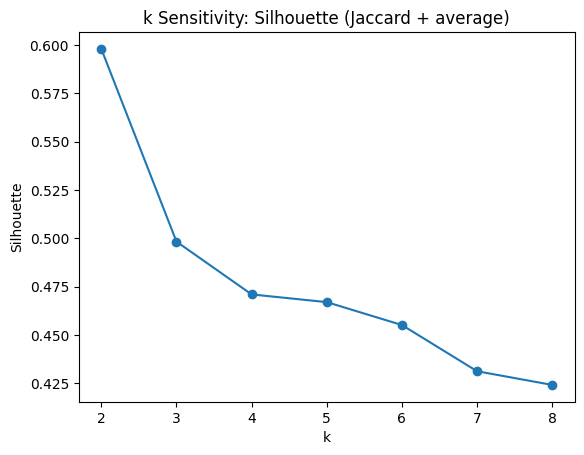

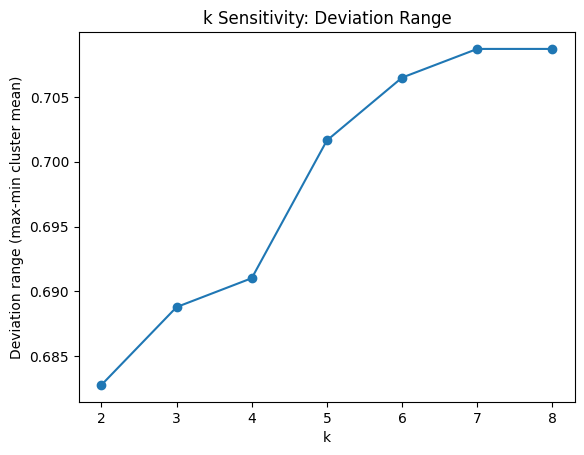

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_df["k"], k_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("k Sensitivity: Silhouette (Jaccard + average)")
plt.show()

plt.figure()
plt.plot(k_df["k"], k_df["dev_range"], marker="o")
plt.xlabel("k")
plt.ylabel("Deviation range (max-min cluster mean)")
plt.title("k Sensitivity: Deviation Range")
plt.show()

# Experiment B — linkage sensitivity

In [ ]:
link_df = run_grid(
    X_bool,
    bob_clean["deviation_score"],
    metrics=("jaccard",),
    linkages=("average", "complete", "single"),
    k_list=(4,)
).sort_values(["linkage"])

link_df

,metric,linkage,k,silhouette,largest_cluster_pct,smallest_cluster_pct,min_cluster_mean_deviation,max_cluster_mean_deviation,dev_range
0,jaccard,average,4,0.470907,0.980149,0.002481,0.225646,0.916667,0.691021
1,jaccard,complete,4,0.351004,0.821340,0.032258,0.182511,0.681600,0.499089
2,jaccard,single,4,0.498293,0.995037,0.002481,0.232729,0.916667,0.683938


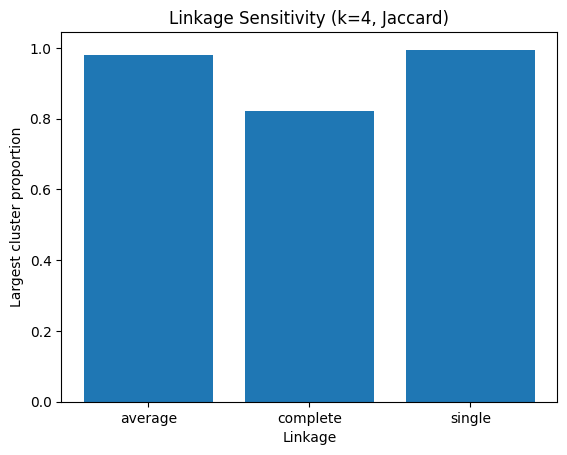

In [ ]:
plt.figure()
plt.bar(link_df["linkage"], link_df["largest_cluster_pct"])
plt.xlabel("Linkage")
plt.ylabel("Largest cluster proportion")
plt.title("Linkage Sensitivity (k=4, Jaccard)")
plt.show()

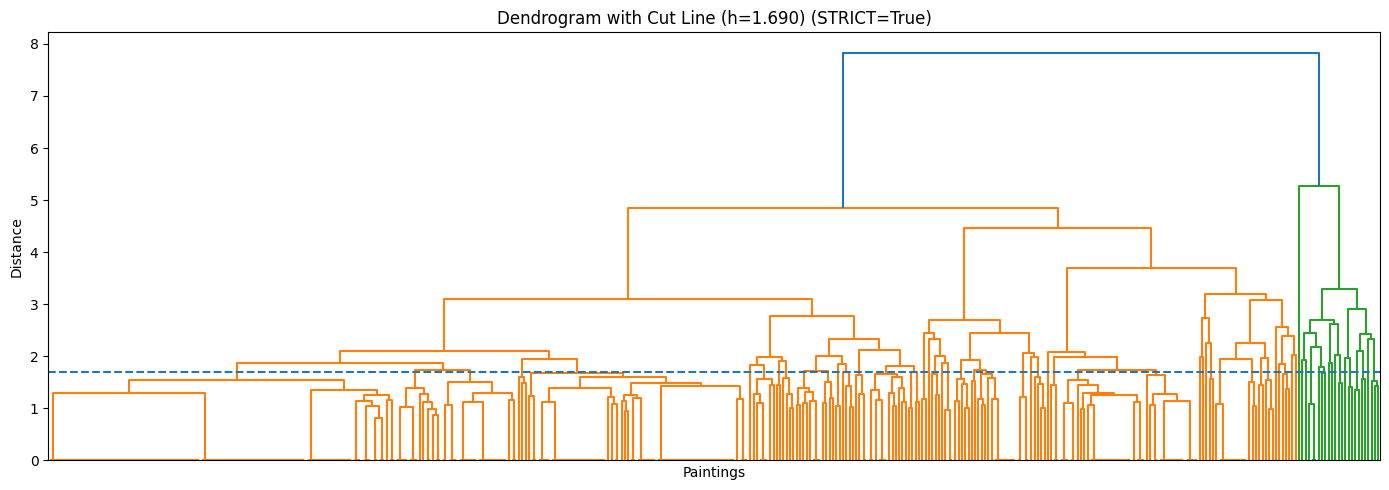

In [ ]:
from scipy.cluster.hierarchy import dendrogram

h = float(np.percentile(Z[:, 2], 85))
plt.figure(figsize=(14, 5))
dendrogram(Z, no_labels=True)
plt.axhline(y=h, linestyle="--")
plt.title(f"Dendrogram with Cut Line (h={h:.3f}) (STRICT={USE_M3_COMPAT})")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Experiment C — metric sensitivity

In [ ]:
metric_df = run_grid(
    X_bool,
    bob_clean["deviation_score"],
    metrics=("jaccard", "hamming", "cosine"),
    linkages=("average",),
    k_list=(4,)
).sort_values("metric")

metric_df

,metric,linkage,k,silhouette,largest_cluster_pct,smallest_cluster_pct,min_cluster_mean_deviation,max_cluster_mean_deviation,dev_range
2,cosine,average,4,0.520221,0.975186,0.004963,0.222977,0.750000,0.527023
1,hamming,average,4,0.361921,0.828784,0.002481,0.179339,0.609890,0.430551
0,jaccard,average,4,0.470907,0.980149,0.002481,0.225646,0.916667,0.691021


dominant cluster stability

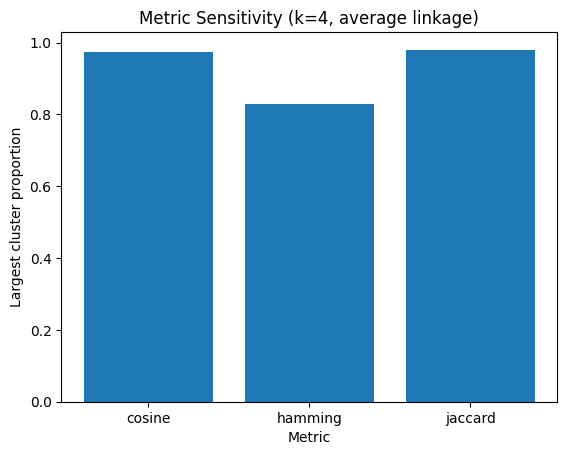

In [ ]:
plt.figure()
plt.bar(metric_df["metric"], metric_df["largest_cluster_pct"])
plt.xlabel("Metric")
plt.ylabel("Largest cluster proportion")
plt.title("Metric Sensitivity (k=4, average linkage)")
plt.show()

Determine whether the separation is significant

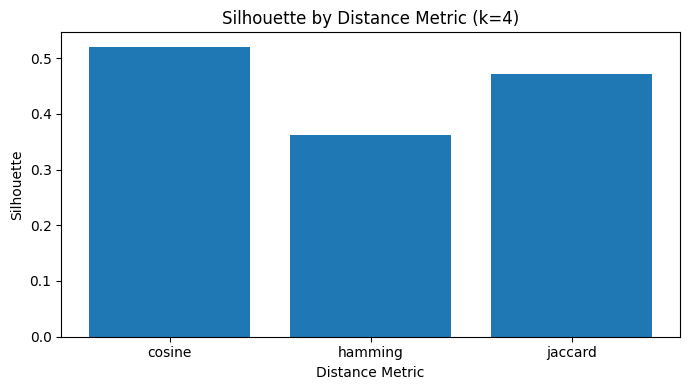

In [ ]:
plt.figure(figsize=(7,4))
plt.bar(metric_df["metric"], metric_df["silhouette"])
plt.xlabel("Distance Metric")
plt.ylabel("Silhouette")
plt.title("Silhouette by Distance Metric (k=4)")
plt.tight_layout()
plt.show()

In [ ]:
hc_summary = pd.concat([k_df, link_df, metric_df], ignore_index=True)
hc_summary.sort_values(["metric","linkage","k"]).head()

,metric,linkage,k,silhouette,largest_cluster_pct,smallest_cluster_pct,min_cluster_mean_deviation,max_cluster_mean_deviation,dev_range
10,cosine,average,4,0.520221,0.975186,0.004963,0.222977,0.750000,0.527023
11,hamming,average,4,0.361921,0.828784,0.002481,0.179339,0.609890,0.430551
0,jaccard,average,2,0.597944,0.997519,0.002481,0.233872,0.916667,0.682795
1,jaccard,average,3,0.498231,0.985112,0.002481,0.227872,0.916667,0.688795
2,jaccard,average,4,0.470907,0.980149,0.002481,0.225646,0.916667,0.691021


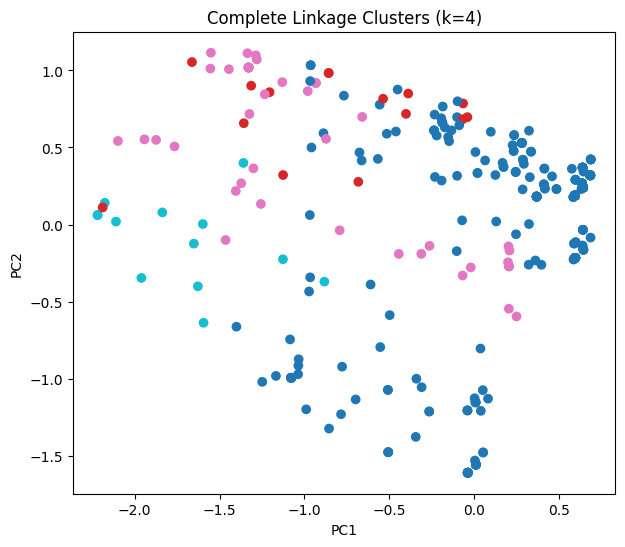

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the integer representation of the palette data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_int)

# Recalculate labels for 'complete' linkage method with k=4
dist_mat_jaccard = pairwise_distances(X_bool, metric="jaccard")
dist_vec_jaccard = squareform(dist_mat_jaccard, checks=False)
Z_complete = linkage(dist_vec_jaccard, method="complete")
labels_complete = fcluster(Z_complete, t=4, criterion="maxclust")

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_complete, cmap="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Complete Linkage Clusters (k=4)")
plt.show()

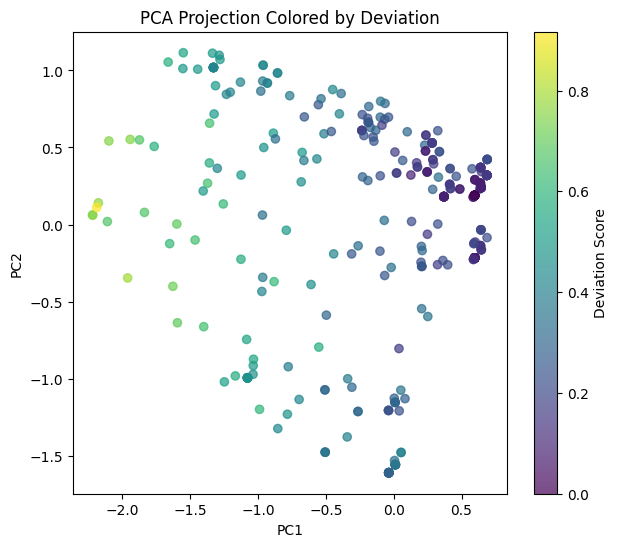

In [ ]:
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=bob_clean["deviation_score"],
            cmap="viridis", alpha=0.7)

plt.colorbar(label="Deviation Score")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection Colored by Deviation")
plt.show()

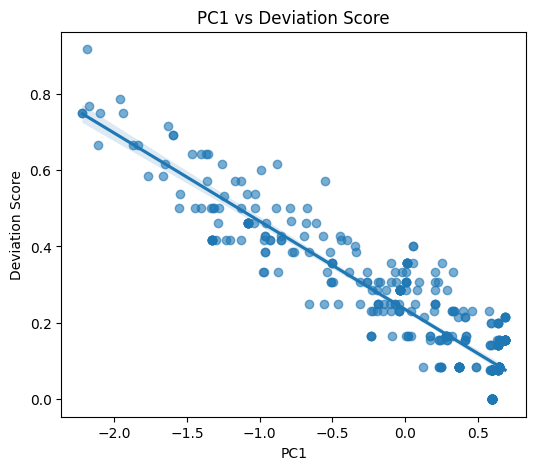

Pearson r: -0.92
p-value: 4.0587465367791855e-165


In [ ]:
import seaborn as sns
from scipy.stats import pearsonr

# Add PC1 to bob_clean DataFrame
bob_clean["PC1"] = X_pca[:, 0]

# Ensure deviation_score is accessed from bob_clean
pc1 = bob_clean["PC1"]
dev = bob_clean["deviation_score"]

plt.figure(figsize=(6,5))
sns.regplot(x=pc1, y=dev, scatter_kws={"alpha":0.6})
plt.xlabel("PC1")
plt.ylabel("Deviation Score")
plt.title("PC1 vs Deviation Score")
plt.show()

# correlation coefficient
r, p = pearsonr(pc1, dev)
print("Pearson r:", round(r,3))
print("p-value:", p)

In [ ]:
# Transform the original data (X_int) into the full PCA space
X_transformed_full = pca.transform(X_int)
n_features = X_int.shape[1]

X_transformed_2_pcs = np.zeros_like(X_transformed_full)
X_transformed_2_pcs[:, :2] = X_transformed_full[:, :2]

X_reconstructed_2 = pca.inverse_transform(X_transformed_2_pcs)

# MSE Error for 2 PCs reconstruction
mse_2 = np.mean((X_int - X_reconstructed_2)**2)
print("Reconstruction MSE (2 PCs):", mse_2)

X_transformed_3_pcs = np.zeros_like(X_transformed_full)
X_transformed_3_pcs[:, :3] = X_transformed_full[:, :3]

# Perform inverse transform
X_reconstructed_3 = pca.inverse_transform(X_transformed_3_pcs)

# MSE Error for 3 PCs reconstruction
mse_3 = np.mean((X_int - X_reconstructed_3)**2)
print("Reconstruction MSE (3 PCs):", mse_3)

Reconstruction MSE (2 PCs): 0.07648033758387401
Reconstruction MSE (3 PCs): 0.07648033758387401


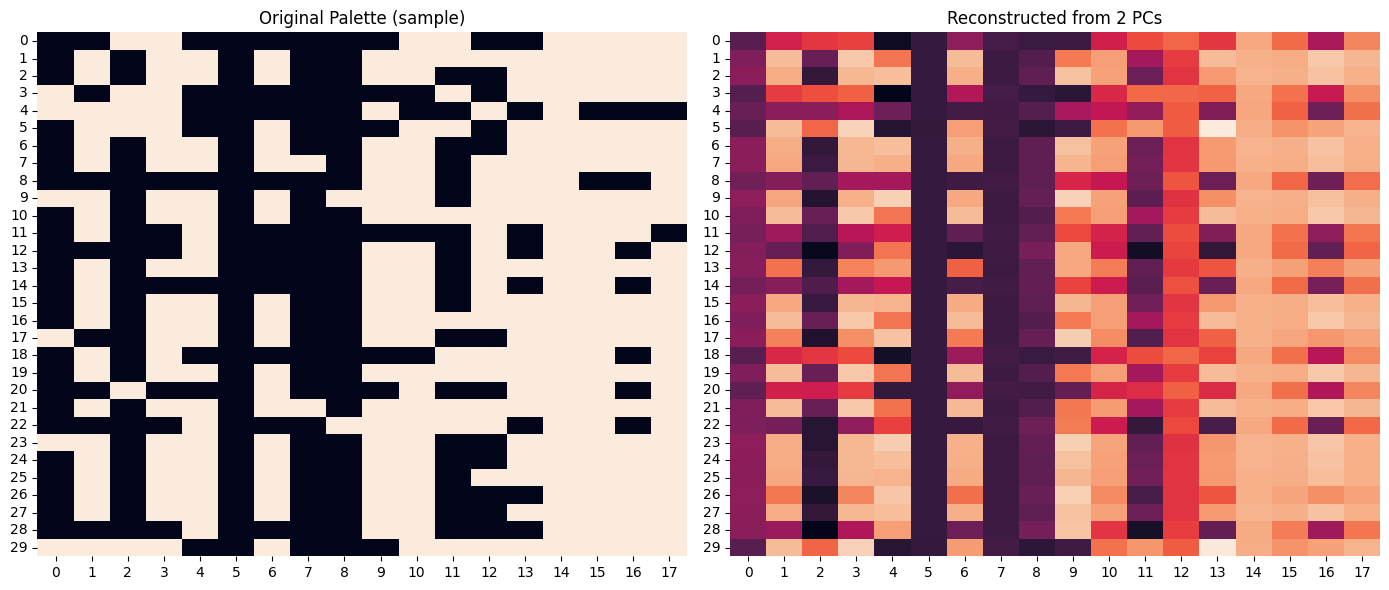

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

X_orig = X_int

# 2PC reconstruction
X_reconstructed = X_reconstructed_2

# Randomly select 30 paintings for display
np.random.seed(42)
idx = np.random.choice(range(X_orig.shape[0]), 30, replace=False)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.heatmap(X_orig[idx], cbar=False)
plt.title("Original Palette (sample)")

plt.subplot(1,2,2)
sns.heatmap(X_reconstructed[idx], cbar=False)
plt.title("Reconstructed from 2 PCs")

plt.tight_layout()
plt.show()

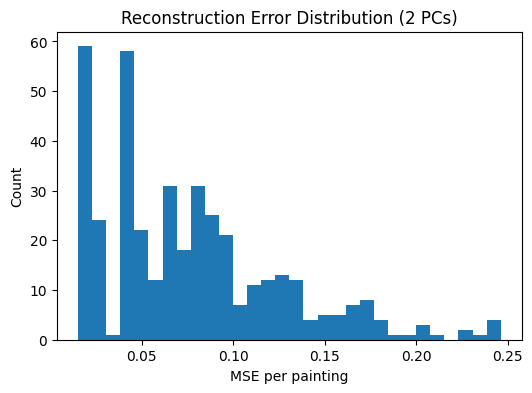

In [ ]:
# reconstruction error for each painting
recon_error = np.mean((X_orig - X_reconstructed)**2, axis=1)

plt.figure(figsize=(6,4))
plt.hist(recon_error, bins=30)
plt.title("Reconstruction Error Distribution (2 PCs)")
plt.xlabel("MSE per painting")
plt.ylabel("Count")
plt.show()

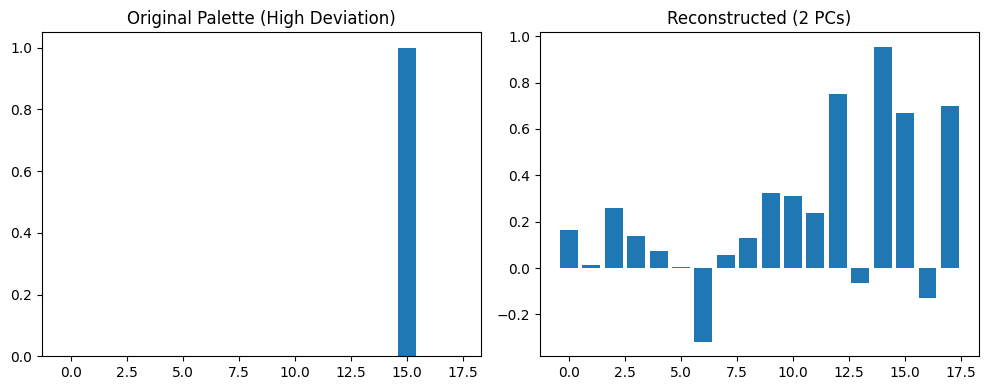

In [ ]:
# Select the painting with the largest deviation
idx_max_dev = np.argmax(dev)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(range(X_orig.shape[1]), X_orig[idx_max_dev])
plt.title("Original Palette (High Deviation)")

plt.subplot(1,2,2)
plt.bar(range(X_reconstructed.shape[1]), X_reconstructed[idx_max_dev])
plt.title("Reconstructed (2 PCs)")

plt.tight_layout()
plt.show()